## Character Recognition - EMNIST + English Font-Number

### Import data

In [1]:
!pip install emnist
!pip install idx2numpy

  Preparing metadata (setup.py) ... - done
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7904 sha256=6b5e4ed7bd8e6a6e622c07a9b94f1119902760e1c0a14b42fc1378f7ac7836f4
  Stored in directory: /root/.cache/pip/wheels/e0/f4/e7/643fc5f932ec2ff92997f43f007660feb23f948aa8486f1107
Successfully built idx2numpy


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt
import os

In [3]:
import idx2numpy
from sklearn.model_selection import train_test_split

X1 = idx2numpy.convert_from_file('/kaggle/input/emnist/emnist_source_files/emnist-byclass-train-images-idx3-ubyte')
X1_test = idx2numpy.convert_from_file('/kaggle/input/emnist/emnist_source_files/emnist-byclass-test-images-idx3-ubyte')

y1 = idx2numpy.convert_from_file('/kaggle/input/emnist/emnist_source_files/emnist-byclass-train-labels-idx1-ubyte')
y1_test = idx2numpy.convert_from_file('/kaggle/input/emnist/emnist_source_files/emnist-byclass-test-labels-idx1-ubyte')

X1_train, X1_val, y1_train, y1_val = train_test_split(X1, y1)

In [4]:
def rescale_data(arr):
    # rescale range from [0, 255] to [0, 1]
    return arr / 255

X1_train = rescale_data(X1_train)
X1_val = rescale_data(X1_val)
X1_test = rescale_data(X1_test)

X1_train.shape, y1_train.shape

((523449, 28, 28), (523449,))

In [5]:
from scipy.ndimage import gaussian_filter

def convert_to_grayscale(array):
    # shape (x, y, 3) --> (x, y)
    return np.dot(array[...,:3], [0.2989, 0.5870, 0.1140])

def apply_gaussian_filter(image):
    return gaussian_filter(image, sigma=1)

def crop_to_roi(image):
    rows = np.any(image > 0, axis=1)
    cols = np.any(image > 0, axis=0)
    row_start, row_end = np.where(rows)[0][[0, -1]]
    col_start, col_end = np.where(cols)[0][[0, -1]]
    return image[row_start:row_end+1, col_start:col_end+1]

def center_image(image, canvas_size=28, border=2):
    h, w = image.shape[:2]
    aspect_ratio = w / h

    # Calculate the new dimensions
    if aspect_ratio > 1:  # Wider than tall
        new_w = canvas_size - 2 * border
        new_h = int(new_w / aspect_ratio)
    else:  # Taller than wide
        new_h = canvas_size - 2 * border
        new_w = int(new_h * aspect_ratio)

    image = np.expand_dims(image, axis=-1)  # Add channel axis (shape -> (h, w, 1) )
    
    # Resize while preserving the aspect ratio
    image_resized = tf.image.resize(image, (new_h, new_w)).numpy()

    image_resized = np.squeeze(image_resized, axis=-1) # remove channel axis again
    
    # Create the centered canvas
    canvas = np.zeros((canvas_size, canvas_size), dtype=image.dtype)
    row_start = (canvas_size - new_h) // 2
    col_start = (canvas_size - new_w) // 2
    canvas[row_start:row_start+new_h, col_start:col_start+new_w] = image_resized

    return canvas


def normalize_image(image):
    return (image / np.max(image))


def preprocess_image(image):
    if len(image.shape) == 3 and image.shape[2] >= 3:
        image = convert_to_grayscale(image)
    elif len(image.shape) == 3 and image.shape[2] == 1:
        image = np.squeeze(image, axis=-1)
        
    image = apply_gaussian_filter(image)
    image = crop_to_roi(image)
    image = center_image(image)
    image = normalize_image(image)
    return image.astype(np.float32)

In [6]:
from PIL import Image

def load_and_preprocess_image(img_path, target_size=(28, 28), inverse=False):
    """
    Load an image and make it a numpy array.
    """
    img = Image.open(img_path)
    
    # grayscale
    img = img.convert("L")
    
    # Resize to 28x28
    img = img.resize((28, 28))
    
    # Convert to NumPy array
    img_array = np.array(img)
    
    # Normalize to [0, 1] and invert if needed
    img_array = img_array / 255.0
    if inverse:
        img_array = 1 - img_array

    img_array = preprocess_image(img_array)
    
    # Add a batch dimension (because the model expects a batch of images)
    img_array = np.expand_dims(img_array, axis=0)

    return img_array

In [7]:
def load_and_preprocess_images_from_dir(dir_path, target_size=(28, 28), inverse=False):
    X = []
    for img in sorted(os.listdir(dir_path)):
        img_path = os.path.join(dir_path, img)
        if not os.path.isfile(img_path):
            continue
            
        img_array = load_and_preprocess_image(img_path, target_size=target_size, inverse=inverse)
        img_array = np.squeeze(img_array, axis=0)
        X.append(img_array)

    X = np.array(X)
    return X

In [8]:
def load_and_preprocess_images_from_dirs(dir_path, target_size=(28, 28), inverse=False):
    X = []
    y = []
    for i, dir in enumerate(sorted(os.listdir(dir_path))):
        sub_dir_path = os.path.join(dir_path, dir)
        for img in sorted(os.listdir(sub_dir_path)):
            img_path = os.path.join(sub_dir_path, img)
            if not os.path.isfile(img_path):
                continue
            
            img_array = load_and_preprocess_image(img_path, target_size=target_size, inverse=inverse)
            img_array = np.squeeze(img_array, axis=0)
            X.append(img_array)
            y.append(i)

    X = np.array(X)
    y = np.array(y)

    return X, y

In [9]:
dir_path = "/kaggle/input/english-fontnumber-recognition/Font/Font"

X2, y2 = load_and_preprocess_images_from_dirs(dir_path, inverse=True)
X2_train, X2_val, y2_train, y2_val = train_test_split(X2, y2)

In [10]:
X_train = np.concatenate([X1_train, X2_train], axis=0)
X_val = np.concatenate([X1_val, X2_val], axis=0)
y_train = np.concatenate([y1_train, y2_train], axis=0)
y_val = np.concatenate([y1_val, y2_val], axis=0)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(570693, 28, 28) (190231, 28, 28) (570693,) (190231,)


In [11]:
from string import ascii_lowercase, ascii_uppercase
alphabet_plus = "0123456789" + ascii_uppercase + ascii_lowercase
label_map = {i: alphabet_plus[i] for i in range(len(alphabet_plus))}

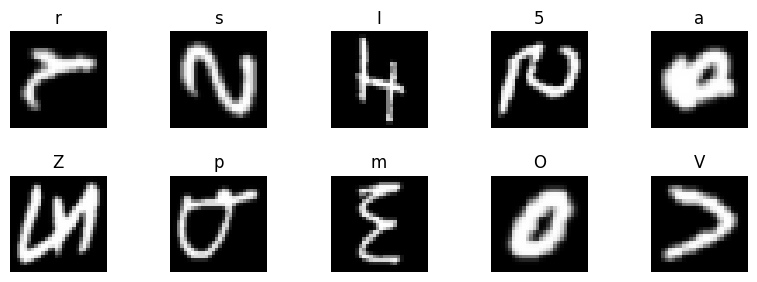

In [12]:
def plot_n_images(X, y, n=10, row_spacing=0.5):
    plt.figure(figsize=(10, 5))
    # Show the first n images if available, otherwise show all images
    for i in range(min(n, X.shape[0], y.shape[0])):  
        plt.subplot(n // 5 + 1, 5, i+1)
        plt.imshow(X[i], cmap='gray')  # Assuming 28x28 images
        plt.title(label_map[y[i]])
        plt.axis('off')

    plt.subplots_adjust(hspace=row_spacing)
    plt.show()

plot_n_images(X_train[10:], y_train[10:])

In [13]:
def one_hot_encode(y):
    return keras.utils.to_categorical(y, num_classes=62)

# y_train = one_hot_encode(y_train)
# y_val = one_hot_encode(y_val)
# y_test = one_hot_encode(y_test)


In [14]:
model = keras.Sequential([
    layers.InputLayer(shape=[28, 28, 1]),
    
    # Data Augmentation
    layers.RandomContrast(factor=0.1),
    layers.RandomRotation(factor=0.1),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomZoom(height_factor=0.1, width_factor=0.1),

    # Block One
    layers.BatchNormalization(),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', kernel_regularizer='l2'),
    layers.MaxPool2D(),

    # Block Two
    layers.BatchNormalization(),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', kernel_regularizer='l2'),
    layers.MaxPool2D(),

    # Block Three
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    layers.GlobalAveragePooling2D(),

    # Head
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu', kernel_regularizer='l2'),
    layers.Dropout(0.5),
    layers.Dense(62, activation='softmax'),
])

In [15]:
from tensorflow.keras.callbacks import EarlyStopping
import shutil

train_model = False

weights_emnist = "/kaggle/input/char-recognition-emnist/keras/default/4/char_recog_model_emnist_v2.weights.h5"
weights_emnist_english = "/kaggle/input/emnist-english-font-number/keras/default/1/char_recog_model_emnist_english.weights.h5"

saved_weights = weights_emnist_english
if os.path.isfile(saved_weights) and not train_model:
    model.load_weights(saved_weights)
    history = None
    
else:
    early_stopping = EarlyStopping(min_delta=0.001, patience=6, restore_best_weights=True)
    
    optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
    )
    
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=256,
        callbacks=[early_stopping]
    )
    
    model.save_weights("char_recog_model_emnist.weights.h5")
    shutil.move("char_recog_model_emnist.weights.h5", "/kaggle/working/char_recog_model_emnist.weights.h5")

In [16]:
import pandas as pd
if history is not None:
    history_frame = pd.DataFrame(history.history)
    history_frame.loc[:, ['loss', 'val_loss']].plot()
    history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

In [17]:
dir_path = "/kaggle/input/letters-and-digits/Images characters/"

dir_path_handwritten_upper = "/kaggle/input/letters-and-digits/Images characters/Handwritten/Uppercase"
dir_path_handwritten_lower = "/kaggle/input/letters-and-digits/Images characters/Handwritten/Lowercase"
dir_path_handwritten_math_simple = "/kaggle/input/letters-and-digits/Images characters/Handwritten/Math - Simple"
dir_path_handwritten_math_complex = "/kaggle/input/letters-and-digits/Images characters/Handwritten/Math - Complex"

dir_path_typed_upper = "/kaggle/input/letters-and-digits/Images characters/Typed/Uppercase"
dir_path_typed_lower = "/kaggle/input/letters-and-digits/Images characters/Typed/Lowercase"
dir_path_typed_latex_math = "/kaggle/input/letters-and-digits/Images characters/Typed/Latex Math"

img_path_zero = "/kaggle/input/letters-and-digits/Images characters/zero.png"
img_path_drawn_zero = "/kaggle/input/letters-and-digits/Images characters/drawn_zero.png"
img_path_drawn_M_close = "/kaggle/input/letters-and-digits/Images characters/M_handwritten_close.png"
img_path_drawn_M_far = "/kaggle/input/letters-and-digits/Images characters/M_handwritten_far.png"

(17, 28, 28)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
(17, 28, 28) (17,)


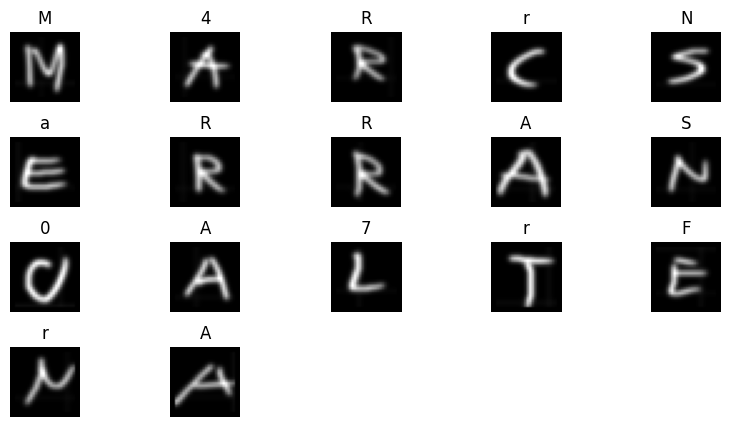

In [18]:
path = dir_path_handwritten_upper
processed_images = load_and_preprocess_images_from_dir(path, inverse=True)
# processed_image = np.array([X_test[2]])

print(processed_images.shape)

# Make the prediction
predictions = model.predict(processed_images)

# For multi-class classification (e.g., 62 classes):
# Get the index of the class with the highest probability
predicted_classes = np.argmax(predictions, axis=1)

print(processed_images.shape, predicted_classes.shape)
plot_n_images(processed_images, predicted_classes, n=17, row_spacing=0.5)

In [19]:
predictions = model.predict(X1_test)

3636/3636 ━━━━━━━━━━━━━━━━━━━━ 129s 35ms/step


In [20]:
from sklearn.metrics import accuracy_score

predicted_classes = np.argmax(predictions, axis=1)
# OH_predicted_classes = one_hot_encode(predicted_classes)
accuracy = accuracy_score(y1_test, predicted_classes)
accuracy

0.8367906604884675

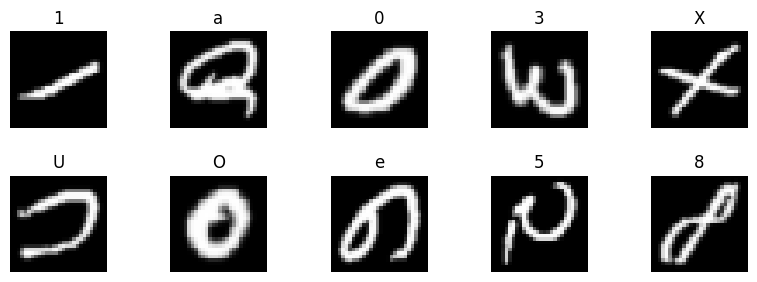

In [21]:
plot_n_images(X1_test, predicted_classes)

### English Font-Number Recognition dataset

#### Dataset Correct Images

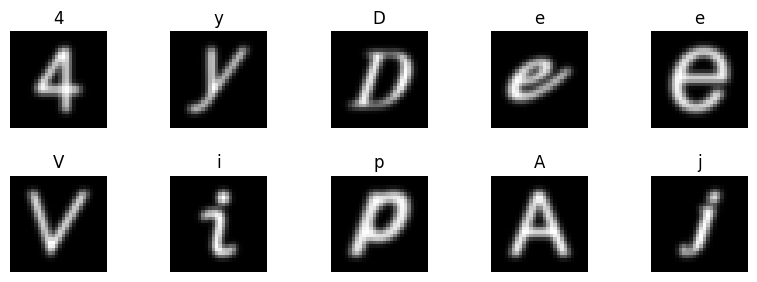

In [22]:
 plot_n_images(X2_val, y2_val)

In [23]:
predictions2 = model.predict(X2)

1969/1969 ━━━━━━━━━━━━━━━━━━━━ 70s 35ms/step


In [24]:
predicted_classes2 = np.argmax(predictions2, axis=1)
print(predicted_classes2.shape, y2.shape)

(62992,) (62992,)


In [25]:
accuracy = accuracy_score(y2, predicted_classes2)
accuracy

0.6896590043180086

#### Dataset Predicted Images

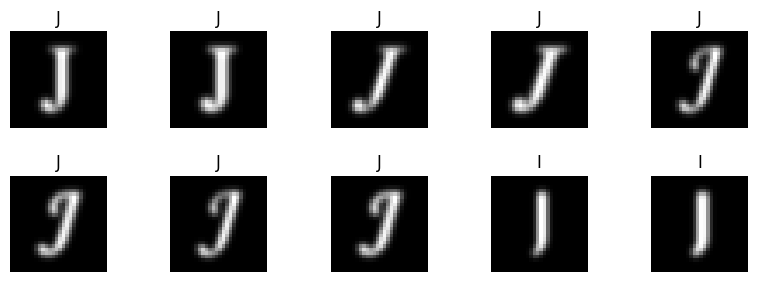

In [26]:
plot_n_images(X2[20000:], predicted_classes2[20000:])